---
### 1. SET SEEDS, SET PARAMETERS, LOAD LIBRARIES AND DATA
---

In [20]:
import numpy as np
import tensorflow as tf
import random as rn

In [21]:
import os
os.environ['PYTHONHASHSEED'] = '0'

In [22]:
np.random.seed(1337)

In [23]:
rn.seed(1337)

In [24]:
tf.random.set_seed(1337)

In [25]:
# import talib # Techical indicators library
# import pandas_ta as ta
import pandas as pd
pd.options.display.max_rows = 260
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import math
from tqdm.notebook import tqdm
from termcolor import colored
from tensorflow import  keras
from tensorflow.keras import layers, metrics
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential 
from keras.callbacks import History 
import json
# import sklearn.metrics as metrics
# from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score
#=================================================================================================================================
# SET PARAMETERS HERE:
name = 'testing_252_close'          
# features = ['SMA5', 'SMA10', 'SMA50', 'EMA20', '%k5', '%d3', 'ADOSC', 'MACDhist', '%R', 'RSI', 'ROC', 'OBV', 'CCI', 'ICSA'] # ti
# features = ['Open', 'High', 'Low', 'Close', 'Volume']                                                                     # ohlcv
features = ['Close']                                                                                                      # close

lookback = 63
train_period = 504
test_period = 252
batch = 252

units = 30
hidden = 2                   # change manually
_epochs = 100
lr = 0.01

dropout = 0.1           
_treshold = 0.001
_loss = 'mean_squared_error'
_act = 'tanh' 
_opt = 'Adam'                   # no effect
scaler = 'MinMaxScaler()'       # no effect
#=================================================================================================================================
# SAVE PARAMETERS TO DICTIONARY:
desc = {
    'features': f'{features}',
    'lookback period': f'{lookback}',
    'training period': f'{train_period}',
    'test period': f'{test_period}',
    'scaler' : scaler,
    'LSTM layer units': f'{units}',
    'hidden layers': f'{hidden}',
    'dropout rate': f'{dropout}',
    'opt': _opt,
    'activation': f'{_act}',
    'lr': f'{lr}',
    'loss': f'{_loss}',
    'epochs': f'{_epochs}',
    'batch_size': f'{batch}',
    'treshold': f'{_treshold}'
}
#------------------------------------------------------------------------------------------
data = pd.read_csv("dane/ohlc_ndx6.csv")
# data = pd.read_csv('dane/ixic_input.csv')
# data = pd.read_csv('dane/sp500_input.csv')

data.reset_index(inplace=True, drop=True)
data['diff'] = data.Close.pct_change(1)

data['class3'] = data['diff'].apply(lambda x: 1 if x > _treshold else (-1 if x < -_treshold else 0))
data.dropna(inplace=True)
display(data.describe().iloc[[3, 7]])

dates = data['Date'].values
closes = data['Close'].values.reshape(data['Close'].values.shape[0], -1).copy()
raw_input = data[features].copy().values
# rise = data['rise'].copy().values
# fall = data['fall'].copy().values
class3 = data['class3'].copy().values
#=================================================================================================================================
def windows(raw_input, closes, dates, lookback, train_period, test_period, targets):

    input_X, target_X, input_Y, target_Y, closes_X, closes_Y, dates_X, dates_Y, scalers_input = [], [], [], [], [], [], [], [], []

    for i in tqdm(range(lookback+train_period, raw_input.shape[0]-test_period, test_period), desc="Generating windows", leave=True): # recalibration

        buf_input_X, buf_target_X, buf_input_Y, buf_target_Y, buf_closes_X, buf_closes_Y, buf_dates_X, buf_dates_Y = [], [], [], [], [], [], [], []

        # normalizing data:
        scaler_input=MinMaxScaler()
        scaler_input.fit(raw_input[i-train_period-lookback:i, :])
        scalers_input.append(scaler_input) # saving only target scaler for inverse purposes in evaluating model's training period

        # training periods:
        for j in range(i-train_period, i, 1):
            buf_input_X.append(scaler_input.transform(raw_input[j-lookback:j, :].copy()))
            buf_target_X.append([targets[j].copy()])
            buf_dates_X.append(dates[j])
            buf_closes_X.append(closes[j].copy())

        # test periods:
        for k in range(i, i+test_period, 1):
            buf_input_Y.append(scaler_input.transform(raw_input[k-lookback:k, :].copy()))
            buf_target_Y.append([targets[k].copy()])
            buf_dates_Y.append(dates[k]) # equals to shape of dates
            buf_closes_Y.append(closes[k].copy())

        # append bufors:
        input_X.append(buf_input_X)
        target_X.append(buf_target_X)
        input_Y.append(buf_input_Y)
        target_Y.append(buf_target_Y)
        closes_X.append(buf_closes_X)
        closes_Y.append(buf_closes_Y)
        dates_X.append(buf_dates_X)
        dates_Y.append(buf_dates_Y)

    # change to numpy arrays from list of lists
    input_X = np.asarray(input_X)
    target_X = np.asarray(target_X)
    input_Y = np.asarray(input_Y)
    target_Y = np.asarray(target_Y)
    closes_X = np.asarray(closes_X)
    closes_Y = np.asarray(closes_Y)
    dates_X = np.asarray(dates_X)
    dates_Y = np.asarray(dates_Y)
    scalers_input = np.asarray(scalers_input)
    # scalers_Y = np.asarray(scalers_Y)

    return (input_X, target_X, input_Y, target_Y, closes_X, closes_Y, dates_X, dates_Y, scalers_input)
#=================================================================================================================================
def model_builder(input, units, dropout, _act, lr, _loss):
    model = tf.keras.Sequential([
        layers.LSTM(units, batch_input_shape=(batch, input.shape[2], input.shape[3]), stateful=True, dropout=dropout, return_sequences=True), #input
        layers.LSTM(units, batch_input_shape=(batch, input.shape[2], input.shape[3]), activation=_act, dropout=dropout, stateful=True, return_sequences=True), # 1st hidden
        layers.LSTM(units, batch_input_shape=(batch, input.shape[2], input.shape[3]), activation=_act, dropout=dropout, stateful=True, return_sequences=False), # 2nd hidden
        # layers.LSTM(units, batch_input_shape=(batch, input.shape[2], input.shape[3]), activation=_act, dropout=dropout, stateful=True, return_sequences=True), # 3rd hidden
        # layers.LSTM(units, batch_input_shape=(batch, input.shape[2], input.shape[3]), activation=_act, dropout=dropout, stateful=True, return_sequences=False), # 4th hidden
        layers.Dense(1)])

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=_loss)
    return model
#=================================================================================================================================
def return_chain(_array, _treshold=0):
    _result=[]
    for i in range(_array.shape[0]):
        if (i==0): continue
        else: _result.append((_array[i] - _array[i-1])/_array[i-1] - _treshold)
    return np.asarray(_result)
#------------------------------------------------------------------------------------------
def returns(predictions, actual_values, _treshold=0, _cost=0.0005):
    _positions=[1]
    _counter=0
    _return=[]
    for i in range(actual_values.shape[0]): # for i in actual values
        if (i==0): continue 
        elif ((predictions[i] > 0 + _treshold or predictions[i] < 0 - _treshold) and (i!=0)): 

            if (predictions[i] > 0 + _treshold): # LONG BUY
                if (_positions[-1]==1):
                    _return.append((actual_values[i]-actual_values[i-1])/actual_values[i-1])
                    _positions.append(1)
                else: 
                    _return.append((actual_values[i]-actual_values[i-1])/actual_values[i-1]-2*_cost)
                    _positions.append(1)

            elif (predictions[i] < 0 - _treshold): # SHORT SALE
                if (_positions[-1]==-1 and i!=1):
                    _return.append((actual_values[i-1]-actual_values[i])/actual_values[i-1])
                    _positions.append(-1)
                else:
                    _return.append((actual_values[i-1]-actual_values[i])/actual_values[i-1]-2*_cost)
                    _positions.append(-1)
        else:
            _counter+=1
            _return.append(0)
            _positions.append(0)
    return (np.asarray(_return), _counter, _positions)
#------------------------------------------------------------------------------------------
# EQUITY LINE - requires return rates
def eq_line(_array, _n_value):
    _result=[]
    _result.append(_n_value)
    for i,x in enumerate(_array):
        if (x>0):
            _result.append(_result[i]*(1+x))
        else:
            _result.append(_result[i]*(1+x))     
    return np.asarray(_result)
#------------------------------------------------------------------------------------------
# ANNUALIZED RETURN RATIO - requires equity line array
def ARC(_equity_array, _scale=252):
    return (_equity_array[-1]/_equity_array[0])**(_scale/len(_equity_array))-1
#------------------------------------------------------------------------------------------
# ANNUALIZED STANDARD DEVIATION - requires return rates
def ASD(_returns, _scale=252):
    return np.std(_returns)*np.sqrt(_scale)
#------------------------------------------------------------------------------------------
# INFORMATION RATIO - requires equity line array
def IR(_equity_array, _returns, _scale=252):
    return ARC(_equity_array, _scale)/ASD(_returns, _scale)
#------------------------------------------------------------------------------------------
# MAXIMUM LOSS DURATION - requires return rates
def MLD(_array, _scale=252):
    _max=0
    _curr=0
    for i in range(_array.shape[0]):
        if (i==0 and _array[0]<0): 
            _curr+=1
            if (_max < _curr): _max=_curr
        elif (i>0 and _array[i-1]<0 and _array[i]<0):
            _curr+=1
            if (_max < _curr): _max=_curr
        elif (i>0 and _array[i-1]<0 and _array[i]>0):
            _curr=0
    return _max/_scale

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,SMA5,SMA10,SMA50,...,ADOSC,MACDhist,%R,RSI,ROC,OBV,CCI,ICSA,diff,class3
min,49.0,127.485001,128.524994,126.250000,127.974998,127.974998,3.174000e+07,127.763002,126.50100,118.084700,...,-4.172101e+09,-162.274241,-100.0,12.033524,-35.666874,3.645480e+09,-332.746415,201000.0,-0.150776,-1.0
max,8892.0,13037.240234,13113.089844,12939.730469,13105.200195,13105.200195,1.425090e+10,12874.598047,12848.36416,12300.456172,...,9.143465e+09,162.718077,-0.0,88.701875,42.497175,1.153361e+12,322.587978,6867000.0,0.187713,1.0


<AxesSubplot:ylabel='Frequency'>

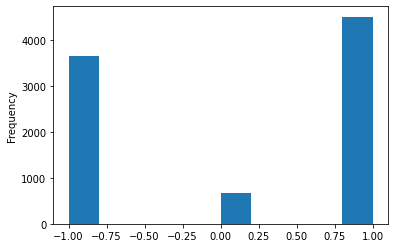

In [26]:
data.class3.plot.hist(bins=10)

---
### 2. GENERATE WINDOWS AND SHOW INPUT / TARGET DIMENSIONS
---

In [27]:
input_X, target_X, input_Y, target_Y, closes_X, closes_Y, dates_X, dates_Y, scalers_X = windows(raw_input, closes, dates, lookback, train_period, test_period, class3)
model_builder(input_X, units, dropout, _act, lr, _loss).summary()

Generating windows:   0%|          | 0/32 [00:00<?, ?it/s]

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (252, 63, 30)             3840      
_________________________________________________________________
lstm_100 (LSTM)              (252, 63, 30)             7320      
_________________________________________________________________
lstm_101 (LSTM)              (252, 30)                 7320      
_________________________________________________________________
dense_33 (Dense)             (252, 1)                  31        
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________


---
### 3. TRAIN AND TEST MODEL
---

In [9]:
_pred=[]
_models=[]
with tqdm(total=input_X.shape[0], desc="Training model and making predictions") as pbar:
    history = History()
    for i in range(input_X.shape[0]): # i/recalibration window

        _model=model_builder(input_X, units, dropout, _act, lr, _loss) # build model architecture
        _models.append(_model)
        buf_pred=[]

        # TRAIN
        # history = _model.fit(input_X[i], target_X[i], epochs=_epochs, batch_size=batch, verbose=0, shuffle=False, validation_split=0.1, callbacks=[history])
        _model.fit(input_X[i], target_X[i], epochs=_epochs, batch_size=batch, verbose=0, shuffle=False, callbacks=[history])

        pred = _model.predict(input_Y[i], batch_size=batch, verbose=0)

        _pred.append(pred)

        pbar.update(1)
_pred=np.asarray(_pred)

Training model and making predictions:   0%|          | 0/32 [00:00<?, ?it/s]

f the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000023DE24F1430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


---
#### 3.1 SAVE PREDICTIONS AND DATES TO .CSV FILE, HYPER-PARAMETERS TO .JSON
---

In [10]:
df = pd.DataFrame(np.vstack((dates_Y.reshape(-1), _pred.reshape(-1), closes_Y.reshape(-1))).T, columns=['Date', 'Pred', 'Real']).set_index('Date')
df.to_csv(f'export-14-04/final/{name}.csv')

with open(f'export-14-04/final/{name}.json', 'w') as fp:
    json.dump(desc, fp, indent=4, sort_keys=False)

---
### 4. RELOAD PRED AND DATES_Y
---

In [11]:
# reload = 'baza_close'
# _pred = pd.read_csv(f'export-14-04/final/{reload}.csv', sep=',', decimal='.')['Pred'].values.reshape(-1, test_period).reshape(-1, test_period)
# dates_Y = pd.read_csv(f'export-14-04/final/{reload}.csv', sep=',', decimal='.')['Date'].values.reshape(-1, test_period).reshape(-1, test_period)

---
### 5. CALCULATE PERFORMANCE STATISTICS
---

<AxesSubplot:ylabel='Frequency'>

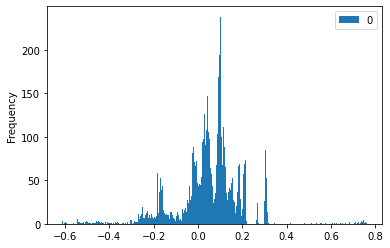

In [12]:
pd.DataFrame(_pred.reshape(-1)).plot.hist(bins=500)

In [13]:
# import itertools
# def seq(bits, value):
#   return [sum(g) for b, g in itertools.groupby(bits) if b==value]
# pos = returns(_pred.copy().reshape(-1), closes_Y.copy().reshape(-1), _treshold=0)[2]

# print(np.mean(seq(pos, 1)), np.mean(seq(pos, -1)))
# np.histogram(pos)

In [14]:
returns_array = returns(_pred.copy().reshape(-1), closes_Y.copy().reshape(-1), _treshold=0, _cost=0.0005)[0]
EquityLine = eq_line(returns_array, closes_Y.copy().reshape(-1)[0])
#---------------------------------------
print(colored("[ARC_BH]", 'blue'), str(np.round(ARC(closes_Y.copy().reshape(-1))*100, 2))+"%")
print(colored("[ARC_EQ]", 'blue'), str(np.round(ARC(EquityLine)*100, 2))+"%")
#---------------------------------------
stats = {
    "[ARC_BH]": str(np.round(ARC(closes_Y.copy().reshape(-1))*100, 2))+"%",
    "[ARC_EQ]": str(np.round(ARC(EquityLine)*100, 2))+"%",
}

[ARC_BH] 12.54%
[ARC_EQ] -1.18%


---
#### 5.1 Save Equity Line and buy-hold
---

In [15]:
pd.DataFrame(np.vstack((dates_Y.reshape(-1), EquityLine)).T, columns=["Date", "Equity Line"]).to_csv(f"export-14-04/final/eq_{name}.csv")

In [16]:
# pd.DataFrame(np.vstack((dates_Y.reshape(-1), closes_Y.reshape(-1))).T, columns=["Date", "NDX"]).to_csv(f"export-14-04/final/bh_{name}.csv")

---
#### 5.2 OVERWRITE PERFORMANCE STATS
---

In [17]:
with open(f'export-14-04/final/{name}.json', 'r') as fp:
    dic = json.load(fp)

with open(f'export-14-04/final/{name}.json','w') as fp:
    dic.update(stats)
    json.dump(dic, fp, indent=4, sort_keys=False)

---
### 6. PLOT EQUITY LINE
---

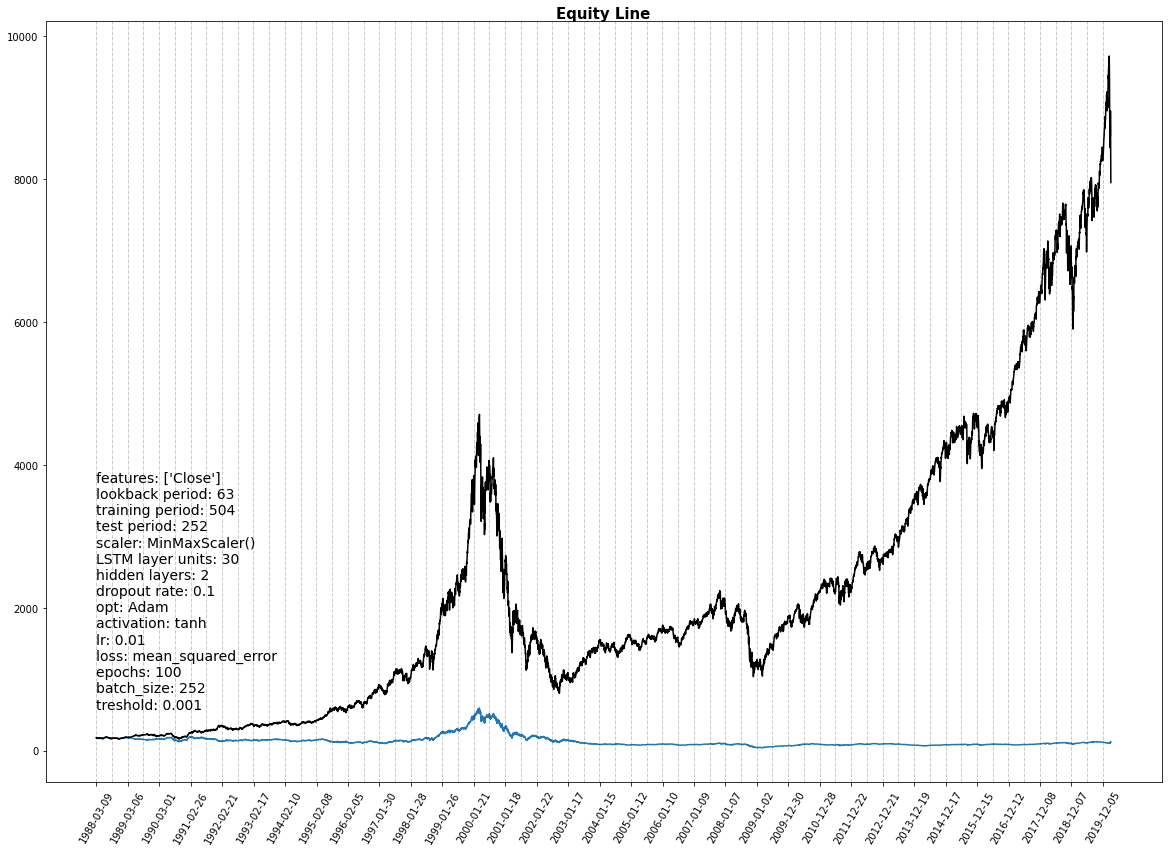

In [18]:
_txt=''''''
for k,v in desc.items():
    _txt += str(k)+": "+str(v)+'\n'

plt.figure(figsize=(20, 14))
plt.text(0, int(np.max(EquityLine)*0.6), _txt, fontsize=14)
plt.plot(dates_Y.reshape(-1), EquityLine)
plt.plot(dates_Y.reshape(-1), closes_Y.reshape(-1), color='black')
ax = plt.gca()
x_ticks = range(0, dates_Y.reshape(-1).shape[0], 250)
xcoords = [x for x in range(_pred.reshape(-1).shape[0]) if (x+1)%125==0 or x==0]
for xc in xcoords:
    plt.axvline(x=xc, c='black', ls='--', alpha=0.2, lw=1)
plt.xticks(x_ticks, fontsize=10, rotation=60)
ax.set_title('Equity Line', va='center', fontsize=15, fontweight='bold')
plt.show()

---
### 7. SIDENOTES
---

In [19]:
# HISTOGRAM ZMIAN PROCENTOWYCH INDEKSU

# np.histogram(data.Close.pct_change(1)[1:].values)
# -----------------------
# __treshold=0.005
# plt.figure(figsize=(20, 7))
# plt.hist(np.asarray([np.round(x, 5) for x in data.Close.pct_change(1)[1:].values]), density=True, bins='auto', edgecolor='#169acf')
# x_ticks = (np.asarray(range(-200, 200, 10))/1000).tolist()
# plt.xticks(x_ticks, fontsize=10, rotation=30)
# plt.axvline(x=-__treshold, c='black', ls='--', alpha=0.5, lw=1)
# plt.axvline(x=__treshold, c='black', ls='--', alpha=0.5, lw=1)
# plt.show()